In [3]:
%pylab inline --no-import-all
import cv2
import sys
import os
import skimage
import skimage.transform
import skimage.exposure

Populating the interactive namespace from numpy and matplotlib


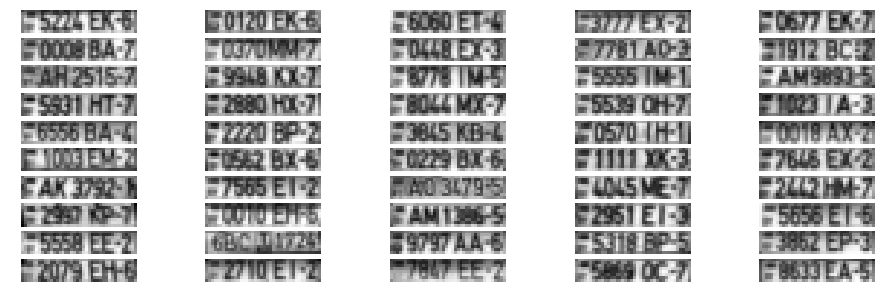

In [4]:
num_columns = 5
preview_plates = 50

plates_paths = list(map(lambda p: os.path.join("data/plates/cropped", p), os.listdir("data/plates/cropped/")))
np.random.shuffle(plates_paths)

num_rows = preview_plates // num_columns
plates = (plt.imread(path) for path in plates_paths[:preview_plates])
fig, axes = plt.subplots(num_rows, num_columns, figsize=(16, num_rows//2))
for y in range(num_rows):
    for x in range(num_columns):
        axes[y][x].axis("off")
        axes[y][x].imshow(plates.__next__())

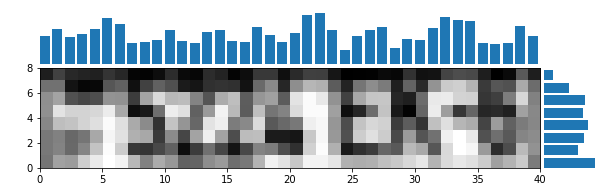

In [5]:
def hor_intencity(image):
    height, width = image.shape
    intencities = [sum(image[row_idx, :]) for row_idx in range(height)]
    return np.array(intencities)

def ver_intencity(image):
    height, width = image.shape
    intencities = [sum(image[:, col_idx]) for col_idx in range(width)]
    return np.array(intencities)

def plot_img_with_projections(img):
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    height, width = img.shape

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    img_ax = ax.imshow(img, cmap='gray', extent=(0, width, 0, height))

    divider = make_axes_locatable(ax)
    
    hist_height = min((30 / height, 0.75))
    hist_width = min((30 / width, 0.75))

    ver_ax = divider.append_axes("right", size=hist_width, pad=0.05)
    ver_ax.axis("off")
    ver_ax.set_ylim(0, height)
    ver_ax.barh(range(height), hor_intencity(img)[::-1], align='edge')

    hor_ax = divider.append_axes("top", size = hist_height, pad=0.05)
    hor_ax.axis("off")
    hor_ax.bar(range(width), ver_intencity(img), align='edge')
    hor_ax.set_xlim(0, width)
    
    
plate = cv2.imread(plates_paths[0])
plate = (skimage.exposure.equalize_hist(cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)) * 255).astype('uint8')
plot_img_with_projections(plate)

In [193]:
from queue import Queue
import matplotlib.animation as animation
import heapq
%matplotlib qt5

def shortest_path_to_bottom(img, start_x, min_x, max_x, animate=False, interval=20):
    if animate:
        fig = plt.figure()
        dbg_image = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        image_obj = plt.imshow(dbg_image, animated=True)
        
        def run_anim(data):
            image_obj.set_array(data)
            return (image_obj, )

    distances = np.full_like(img, np.infty, dtype=float)

    height, width = img.shape
    max_y = height - 1

    visited = set()
    candidates = {0: (0, start_x)} # key is distance, value is point
    distances[0, start_x] = 0
    backTrack = {}      # {point => previousPoint} to track path
    
    def restore_path_back(pfrom, pto):
        track = [pfrom]
        current = pfrom
        while(current != pto):
            current = backTrack[current]
            track.append(current)
        return track
    
    def new_candidate(candidates):
        min_distance = min(candidates)
        return candidates.pop(min_distance)        

    def data_gen(candidates):
        while len(candidates):
            current = new_candidate(candidates)
            y, x = current
            
            if y == max_y: # reached bottom
                shortest_path = restore_path_back(current, (0, start_x))
                if animate:
                    for i in range(1000 // interval):
                        dbg_image[current] = np.array((0, (i % 2)*255, 0), dtype=dbg_image.dtype)
                        yield dbg_image
                    for i in range(1000 // interval):
                        for point in shortest_path[1:-1]:
                            dbg_image[point] = np.array((0, (i % 2)*255, (i % 2)*255), dtype=dbg_image.dtype)
                        yield dbg_image
                else:
                    yield shortest_path
                break
                
            if current in visited:
                continue    
            visited.add(current)

            left = (y, x-1)
            right = (y, x+1)
            down = (y+1, x)
            for neighbour in (left, right, down):
                y, x = neighbour
                if x < min_x or x > max_x or y < 0 or y > max_y or neighbour in visited:
                    continue

                if neighbour is left or neighbour is right:
                    horizontal_multiplier = 1#.05
                else:
                    horizontal_multiplier = 1
                                        
                step_cost = abs(int(img[current]) - int(img[neighbour]))
                symbol_cross_cost = 2 * (255 - img[neighbour])
                newDistance = horizontal_multiplier * (distances[current] + step_cost + symbol_cross_cost)
                if newDistance < distances[neighbour]:   
                    distances[neighbour] = newDistance
                    backTrack[neighbour] = current
                    candidates[newDistance] = neighbour
                                    
                if animate:
                    dbg_image[neighbour] = img[neighbour]
                    dbg_image[neighbour][2] = 255

            
            if animate:
                if current == (0, start_x):
                    dbg_image[0, start_x] = np.array((0, 255, 0), dtype=dbg_image.dtype)
                else:
                    dbg_image[current] = img[current]
                    dbg_image[current][0] = 255
                yield dbg_image
            else:
                yield None
            

    if animate:
        return animation.FuncAnimation(fig, run_anim, data_gen(candidates), interval=interval, blit=True)
    else:
        shortest_path = [x for x in data_gen(candidates) if x is not None][0]
        return shortest_path

In [201]:
plate = cv2.imread("/home/denis/D/plate_good.jpg")
plate = (skimage.exposure.equalize_hist(cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)) * 255).astype('uint8')

In [215]:
import cProfile as profile
import copy

def split_symbols(plate_, show=False):
    plate = cv2.resize(plate_,None,fx=2, fy=2, interpolation = cv2.INTER_CUBIC)
    height, width = plate.shape

    if show:
        img = cv2.cvtColor(np.zeros_like(plate), cv2.COLOR_GRAY2RGB)
        fill_value = np.array((255, 0, 0), dtype=img.dtype)
    
    def show_path(path):
        if not show:
            return
        for point in path:
            img[point] = fill_value
        
    min_symbol_size = max((plate.shape[0] // 3, 8))
    step = min_symbol_size // 2
    nstarts = width // step
    
    for start in range(nstarts):
        start_x = start * step
        path = shortest_path_to_bottom(plate, start_x, max((start_x-1.5*step, 0)), min((start_x+1.5*step-1, width-2)))
        show_path(path)

    if show:
        plate_rgb = cv2.cvtColor(plate, cv2.COLOR_GRAY2RGB)
        result = cv2.addWeighted(plate_rgb, 0.7, img, 1, 1)
        plt.imshow(result)

profiler = profile.Profile()
profiler.enable()
split_symbols(plate)
profiler.disable()
profiler.print_stats(sort='tottime')

split_symbols(plate, True)

         16455 function calls in 0.029 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     2020    0.020    0.000    0.027    0.000 <ipython-input-193-f6fd7c38efde>:38(data_gen)
     2037    0.002    0.000    0.002    0.000 {built-in method builtins.min}
     2017    0.002    0.000    0.005    0.000 <ipython-input-193-f6fd7c38efde>:34(new_candidate)
     3819    0.001    0.000    0.001    0.000 {built-in method builtins.abs}
       20    0.001    0.000    0.027    0.001 <ipython-input-193-f6fd7c38efde>:101(<listcomp>)
     1980    0.001    0.000    0.001    0.000 {method 'add' of 'set' objects}
     2017    0.001    0.000    0.001    0.000 {method 'pop' of 'dict' objects}
     2017    0.001    0.000    0.001    0.000 {built-in method builtins.len}
        1    0.000    0.000    0.029    0.029 <ipython-input-215-13a1bc815faf>:4(split_symbols)
       20    0.000    0.000    0.028    0.001 <ipython-input-193-f6fd7c38efde>:6(s

In [213]:
start_x = 20
delta = 5
shortest_path_to_bottom(plate, start_x, start_x-delta, start_x+delta, True)

In [214]:
%timeit split_symbols(plate)

14.9 ms ± 174 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [205]:
plate = cv2.imread(plates_paths[0])
plate = (skimage.exposure.equalize_hist(cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)) * 255).astype('uint8')
height, width = plate.shape

start_x = 20
delta = 5
shortest_path_to_bottom(plate, start_x, start_x-delta, start_x+delta, True, 40)

In [206]:
%timeit split_symbols(plate)
split_symbols(plate, True)

13.4 ms ± 278 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
